# Process Mining
## Inclusion
In the lecture you've seen the basic concepts of Process Mining: the concepts of process, events, event data and process model; as well as what the unsupervised (Process Discovery) and supervised (Conformance Checking) parts of Process Mining are.

You also installed pm4py, the Python Process Mining suite developed here in Aachen by the PADS team.

**IMPORTANTE: THERE HAVE BEEN UPDATES AND BUGFIXES TO THE PACKAGE. PLEASE UPGRADE THE pm4py PACKAGE TYPING IN A TERMINAL:**

`pip install pm4py --upgrade`

To include it, and also to check that the installation has been successful, you can simply import it:

In [17]:
import pm4py

If the command just returns the prompt and no error messages are dispayed it means that the inclusion - and thus the installation - was successful.

Notice that, to allow for flexibility in the code and more importantly to allow for implementation of many versions of every algorithm, pm4py heavily relies on the **factory** design pattern: https://en.wikipedia.org/wiki/Factory_(object-oriented_programming).
## Importing logs
Let's start from the acquisition of an event log from a file. In this case, we are going to use the importer for the XES format.

The XES format (eXtensible Event Stream) is a de-facto standard in Process Mining, and many of the most important event logs available in the community and in academic research are in this format. It follows the XML format.

It is also possible to acquire the logs in the simpler CSV format, where you simply have each event represented by attributed in a line, separated by a comma.

In [18]:
# Importing a XES event log
from pm4py.objects.log.importer.xes import factory as xes_importer

log = xes_importer.import_log('roadtraffic50traces.xes')

As you can see, the `log` object is iterable, so you can treat it as a list of traces.
A trace is simply modeled as a dictionary. The two keys in the trace dictionary are `attributes`, which contains a dictionary with the trace attributes, and `events`, which has a list as value. The list contains dictionaries: each entry in the list contains the event attributes, as pairs key-value.

**Caveat**: in order to promote simplicity, the behaviour of the `trace` class is a list of events. Do not be fooled by the visualization! To access to the trace attributes, the  


This way, you're able to manipulate logs, traces and events using the basic operations on list and dictionaries that we say in lecture 2.

In [19]:
print(log[0])
print(len(log))

{'attributes': {'concept:name': 'A1'}, 'events': [{'amount': 35.0, 'org:resource': '561', 'dismissal': 'NIL', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2006, 7, 24, 0, 0), 'article': 157, 'points': 0}, {'concept:name': 'Send Fine', 'lifecycle:transition': 'complete', 'expense': 11.0, 'time:timestamp': datetime.datetime(2006, 12, 5, 0, 0)}]}
51


### Now your turn!
- Write a function to filter a log deleting all the traces shorter than a certain number of events (parameters: log, minimum length of traces).
- Write a function to estract the set of resources from the event log.
  - **Caveat**: not all the events have a resource in this log!
- Write a function to filter a log deleting all the events not performed by a certain resource (parameters: log, resource to filter).


In [20]:
# Your answer:

def filter_min_len(log, min_len):
    return [trace for trace in log if len(trace)>=min_len]

def extract_resources(log):
    return set([event['org:resource'] for trace in log for event in trace if 'org:resource' in event.keys()])

def filter_resource(log, resource):
    return [[event for event in trace if 'org:resource' in event.keys() and event['org:resource'] != resource] for trace in log]

print(len(log))
print(len(filter_min_len(log, 5)))
print(filter_resource(log, '561')[0])
print(extract_resources(log))
print(extract_resources(filter_resource(log, '561')))

51
32
[]
{'541', '561', '537', '550'}
{'541', '537', '550'}


## Other filtering functionalities
In pm4py it is possible to process and filter an event log in many ways.
Firstly, in case the imported log is not sorted, you can explicitly sort traces by timestamp of the first event with

In [21]:
#log.sort()

For example, you can filter on a certain time interval for traces:

In [22]:
# Filtering on timestamps
from pm4py.algo.filtering.tracelog.timestamp import timestamp_filter

filtered_log = timestamp_filter.filter_traces_contained(log, "2007-03-09 00:00:00", "2012-01-18 23:59:59")
print(len(log))
print(len(filtered_log))

51
34


This other version of timestamp filtering keeps also traces that intersect with the time interval:

In [23]:
from pm4py.algo.filtering.tracelog.timestamp import timestamp_filter

filtered_log = timestamp_filter.filter_traces_intersecting(log, "2007-03-09 00:00:00", "2012-01-18 23:59:59")
print(len(log))
print(len(filtered_log))

51
49


Another useful filter is the one on start and end activities. I can fetch the set of start and end activities of the log and filter on them in this way:

In [24]:
# Visualizing start and end activities and filtering on them
from pm4py.algo.filtering.tracelog.start_activities import start_activities_filter

log_start = start_activities_filter.get_start_activities(log)
print(log_start)

filtered_log = start_activities_filter.apply(log, ['Create Fine'])
print(len(filtered_log))

{'Create Fine': 51}
51


In [25]:
from pm4py.algo.filtering.tracelog.end_activities import end_activities_filter

log_end = end_activities_filter.get_end_activities(log)
print(log_end)

filtered_log = end_activities_filter.apply(log, ['Send for Credit Collection', 'Payment'])
print(len(filtered_log))

{'Send Fine': 7, 'Send for Credit Collection': 22, 'Payment': 21, 'Send Appeal to Prefecture': 1}
43


## Mine for a model using the Inductive Miner
Next, we are going to see how you discover automatically a process model from an event log. The discovery algorithm we are going to use is the one you have seen in detail in the lecture: the Inductive Miner.

The Inductive Miner searches for a process tree that represents the process by building a directly-follow graph of the event log, and searching for a "cut": a separation of the graph that is then converted to a construct in a process tree. The procedure is repeated for the subgraph obtained by the cut.

In [26]:
# Mining for a process tree
from pm4py.algo.discovery.inductive import factory as inductive_miner

tree = inductive_miner.apply_tree(log)

This gives us a process tree for the log we have acquired.

Notice that, since a process tree is easily convertible in a Petri net, there is also the way to directly extract a Petri net (together with the respective markings for replay) with the Inductive Miner:

In [27]:
# Mining for a Petri net
net, initial_marking, final_marking = inductive_miner.apply(log)

This is especially useful when proceeding with other analysis on the model, since there are a huge variety of Process Mining algorithms applicable on Petri nets.
## Visualizing models
Once obtained the models I can also visualize them with Graphviz. Visualizing a model also works as a factory pattern:

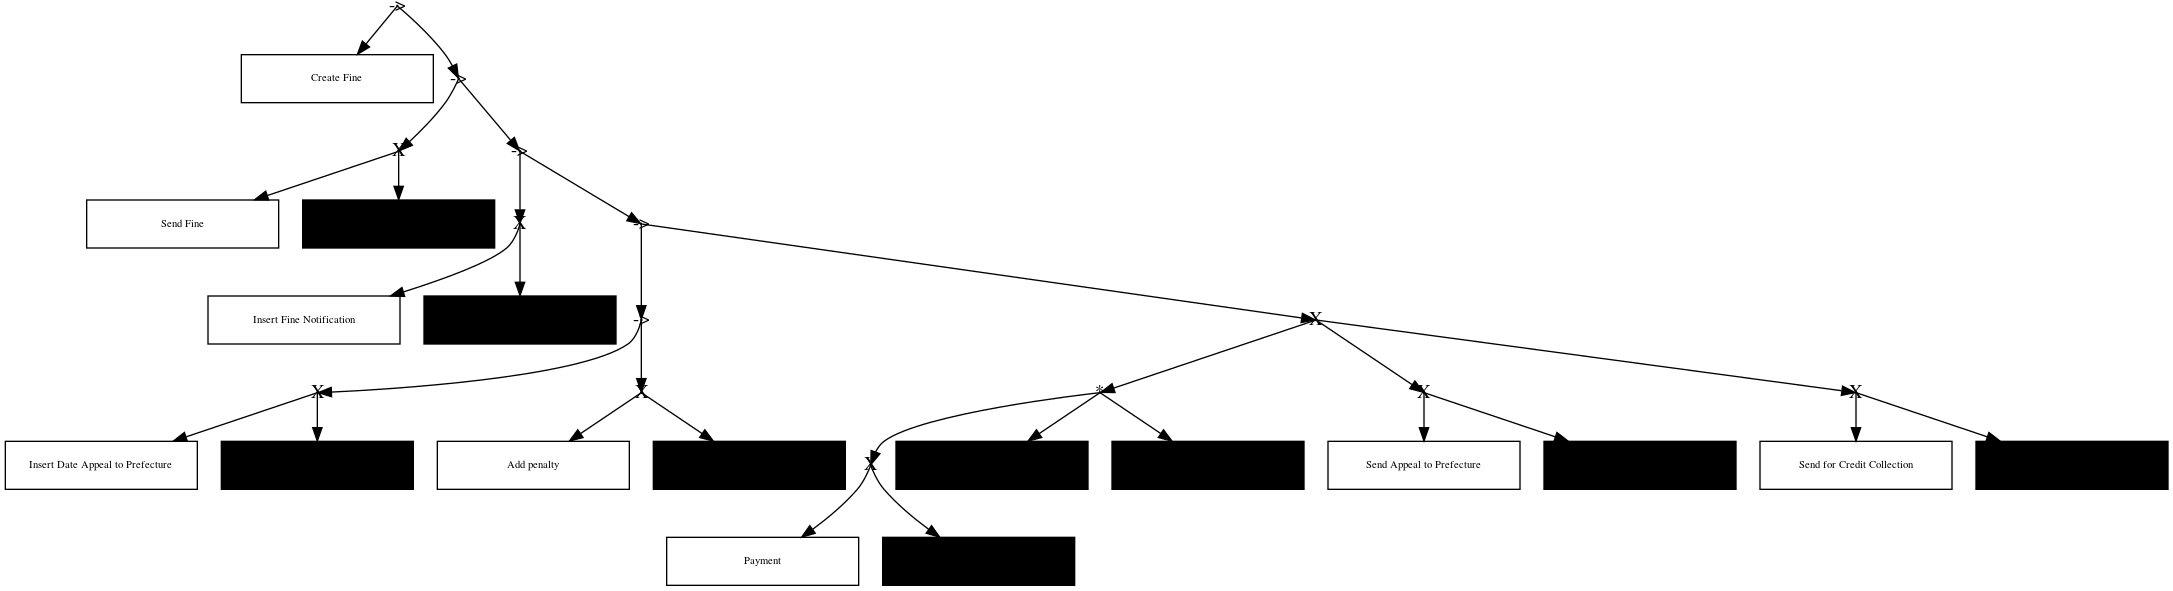

In [28]:
# Process tree visualization
from pm4py.visualization.process_tree import factory as pt_vis_factory

gviz_tree = pt_vis_factory.apply(tree)
pt_vis_factory.view(gviz_tree)

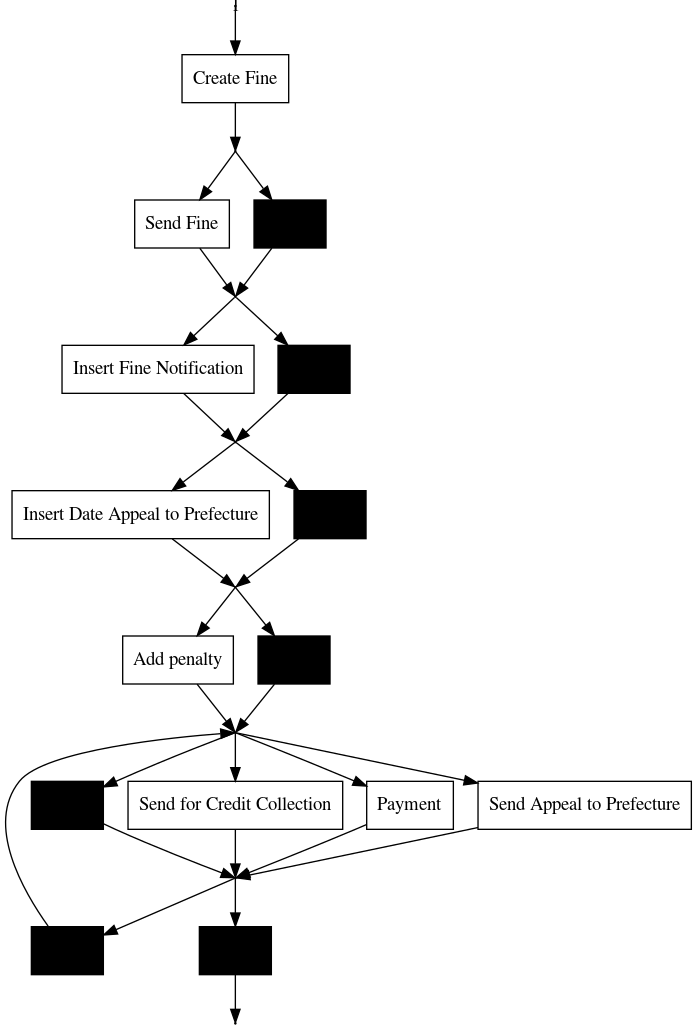

In [29]:
# Petri net visualization
from pm4py.visualization.petrinet import factory as pn_vis_factory

gviz_pn = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz_pn)

## Directly-follow graphs
In the lecture, you have also seen another type of very simple process model: the directly-follow graph. You can create a directly follow graph with pm4py:

In [30]:
# Mining for a directly-follow graph
from pm4py.algo.discovery.dfg import factory as dfg_factory

dfg = dfg_factory.apply(log)

And I can then visualize it:

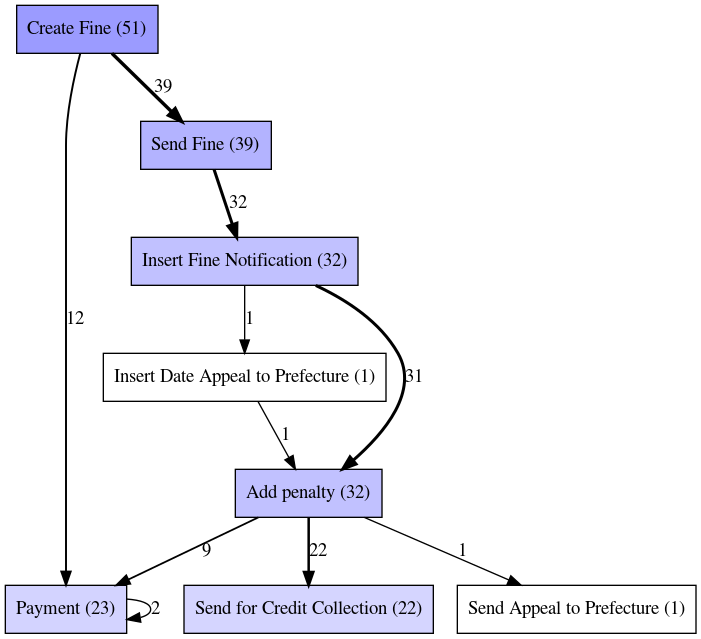

In [31]:
# Directly-follow graph visualization
from pm4py.visualization.dfg import factory as dfg_vis_factory

gviz_dfg = dfg_vis_factory.apply(dfg, log=log, variant='frequency')
dfg_vis_factory.view(gviz_dfg)

The default visualization decorated the graph with frequency information. To get the performance perspective, simply use

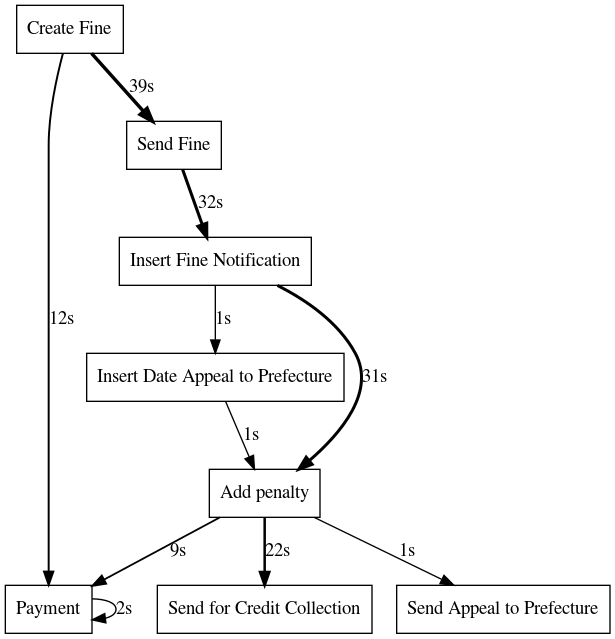

In [32]:
gviz_dfg = dfg_vis_factory.apply(dfg, log=log, variant='performance')
dfg_vis_factory.view(gviz_dfg)

**Question**: why do we use the Inductive Miner (which builds a directly-follow graph as intermediate step) to mine for a process tree, instead of performing our analysis on the directly-follow graph?

**Answer**: there are many differences between a process tree and a directly-follow graph, but the main feature is that *the first has a clear execution semantic, while the second has not.* So, it is not possible for example to perform replay or play out from a directly-follow graph, nor computing conformance based on token replay. 
## Converting models
Lastly, it is also possible to explicitly convert process models. As you have seen in the lecture, every process model is convertible into a Petri net (but not the opposite).

In [33]:
# Converting a process tree into a Petri net
from pm4py.objects.conversion.tree_to_petri import factory as tree_petri_converter

net, initial_marking, final_marking = tree_petri_converter.apply(tree)
gviz_pn = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz_pn)

ModuleNotFoundError: No module named 'pm4py.objects.conversion.tree_to_petri'

## Executing the Token-based Replay of an event log on a process model
Next, having an event log and a process model it is possible to replay the log on top of the model obtaining replay metrics; more specifically, in the case of a Petri net it is possible to obtain token counts (produced, consumed, missing and remaining) for every single trace. The token-based replay implemented in pm4py allows to do it on an entire log with a one-liner:

In [34]:
# Computing trace fitness
from pm4py.algo.conformance.tokenreplay import factory as token_based_replay_factory
print(log[0])
token_replay_result = token_based_replay_factory.apply(log, net, initial_marking, final_marking)
print(token_replay_result[0])

{'attributes': {'concept:name': 'A1'}, 'events': [{'amount': 35.0, 'org:resource': '561', 'dismissal': 'NIL', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2006, 7, 24, 0, 0), 'article': 157, 'points': 0}, {'concept:name': 'Send Fine', 'lifecycle:transition': 'complete', 'expense': 11.0, 'time:timestamp': datetime.datetime(2006, 12, 5, 0, 0)}]}
{'trace_is_fit': True, 'trace_fitness': 1.0, 'activated_transitions': [Create Fine, Send Fine, skip_3, skip_4, skip_5, skip_9, tau_1], 'reached_marking': ['sink:1'], 'enabled_transitions_in_marking': set(), 'transitions_with_problems': [], 'missing_tokens': 0, 'consumed_tokens': 2, 'remaining_tokens': 0, 'produced_tokens': 2}


The token-based replay returns an array of results (a result for each trace). As you can see, the results are a dictionary that  provides a number of pieces of information about the replay of that trace:
- Whether if it fits the model or not
- The trace fitness score
- The sequence of activated transitions
- The marking reached by the replay
- The transitions enabled on the marking reached by the replay
- The set of transitions where the deviations happened
- The token counts:
  - Missing tokens
  - Consumed tokens
  - Remaining tokens
  - Produced tokens

### Now your turn!
Let's see what happens with a non conforming trace.
The first trace is composed by just two event. Append a copy of the first event at the end opf the trace, and perform token replay. **Hint**: the token_based_replay_factory.apply method accepts a log (list of traces) as input, if you just pass a trace it won't work.

In [ ]:
# Your answer:

trace = list(log[0])
trace.append(log[0][0])

print(token_based_replay_factory.apply([log[0]], net, initial_marking, final_marking))
print()
print(token_based_replay_factory.apply([trace], net, initial_marking, final_marking))

## Computing the log fitness using the results of the Token-based Replay
Getting the fitness on the whole event log requires an inclusion from the evaluation package of pm4py. What this method does is exactly the same, except for the result format that is returned: in this case we simply get the log fitness.

In [ ]:
# Computing log fitness
from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory

fitness_tokenbasedreplay = replay_fitness_factory.apply(log, net, initial_marking, final_marking)
print(fitness_tokenbasedreplay)